### Importing from scripts directory

In [35]:
import sys
sys.path.append('../scripts') 
from EDA import * 
import warnings
warnings.filterwarnings('ignore')

## Loading and cleaning datasets

In [36]:
tesla='TSLA'
vanguard='BND'
spdr='SPY'

# Set visualization style
sns.set(style="darkgrid")
sns.set_palette("bright")  # Set a built-in palette


# loading the data from yfinance for tesla, vnguard and spdr from 2015 - 2024
tesla_df = load_and_clean_data(tesla)
vanguard_df = load_and_clean_data(vanguard)
spdr_df = load_and_clean_data(spdr)

#displaying forst five rows
display(tesla_df.head())
display(vanguard_df.head())
display(spdr_df.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume,Date,Daily Return
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA,,
Date,,,,,,,,
2015-01-02 00:00:00+00:00,14.620667,14.620667,14.883333,14.217333,14.858000,71466000,2015-01-02 00:00:00+00:00,NaN
2015-01-05 00:00:00+00:00,14.006000,14.006000,14.433333,13.810667,14.303333,80527500,2015-01-05 00:00:00+00:00,-0.042041
2015-01-06 00:00:00+00:00,14.085333,14.085333,14.280000,13.614000,14.004000,93928500,2015-01-06 00:00:00+00:00,0.005664
2015-01-07 00:00:00+00:00,14.063333,14.063333,14.318667,13.985333,14.223333,44526000,2015-01-07 00:00:00+00:00,-0.001562
2015-01-08 00:00:00+00:00,14.041333,14.041333,14.253333,14.000667,14.187333,51637500,2015-01-08 00:00:00+00:00,-0.001564


Price,Adj Close,Close,High,Low,Open,Volume,Date,Daily Return
Ticker,BND,BND,BND,BND,BND,BND,,
Date,,,,,,,,
2015-01-02 00:00:00+00:00,63.358730,82.650002,82.690002,82.419998,82.430000,2218800,2015-01-02 00:00:00+00:00,NaN
2015-01-05 00:00:00+00:00,63.542747,82.889999,82.919998,82.699997,82.739998,5820100,2015-01-05 00:00:00+00:00,0.002904
2015-01-06 00:00:00+00:00,63.726761,83.129997,83.379997,83.029999,83.029999,3887600,2015-01-06 00:00:00+00:00,0.002896
2015-01-07 00:00:00+00:00,63.765079,83.180000,83.279999,83.050003,83.139999,2433400,2015-01-07 00:00:00+00:00,0.000601
2015-01-08 00:00:00+00:00,63.665359,83.050003,83.110001,82.970001,83.110001,1873400,2015-01-08 00:00:00+00:00,-0.001564


Price,Adj Close,Close,High,Low,Open,Volume,Date,Daily Return
Ticker,SPY,SPY,SPY,SPY,SPY,SPY,,
Date,,,,,,,,
2015-01-02 00:00:00+00:00,173.173782,205.429993,206.880005,204.179993,206.380005,121465900,2015-01-02 00:00:00+00:00,NaN
2015-01-05 00:00:00+00:00,170.046310,201.720001,204.369995,201.350006,204.169998,169632600,2015-01-05 00:00:00+00:00,-0.018060
2015-01-06 00:00:00+00:00,168.444656,199.820007,202.720001,198.860001,202.089996,209151400,2015-01-06 00:00:00+00:00,-0.009419
2015-01-07 00:00:00+00:00,170.543640,202.309998,202.720001,200.880005,201.419998,125346700,2015-01-07 00:00:00+00:00,0.012461
2015-01-08 00:00:00+00:00,173.569931,205.899994,206.160004,203.990005,204.009995,147217800,2015-01-08 00:00:00+00:00,0.017745


### descriptive statistics

In [37]:
# Displaying Basic descriptive statistics
display_basic_stats(tesla_df, tesla)
display_basic_stats(vanguard_df, vanguard)
display_basic_stats(spdr_df, spdr)

Basic Statistics for TSLA:
 Price     Adj Close        Close         High          Low         Open  \
Ticker         TSLA         TSLA         TSLA         TSLA         TSLA   
count   2474.000000  2474.000000  2474.000000  2474.000000  2474.000000   
mean     111.438965   111.438965   113.895836   108.869421   111.461872   
std      110.120450   110.120450   112.643277   107.541830   110.208156   
min        9.578000     9.578000    10.331333     9.403333     9.488000   
25%       17.066167    17.066167    17.368167    16.790167    17.058499   
50%       25.043000    25.043000    25.279000    24.462334    24.986667   
75%      216.865002   216.865002   221.910004   212.084999   217.264999   
max      409.970001   409.970001   414.496674   405.666656   411.470001   

Price         Volume Daily Return  
Ticker          TSLA               
count   2.474000e+03  2473.000000  
mean    1.125745e+08     0.001799  
std     7.449619e+07     0.035802  
min     1.062000e+07    -0.210628  
25%  

## Exploratory data analysis

### Adjusted close price overtime

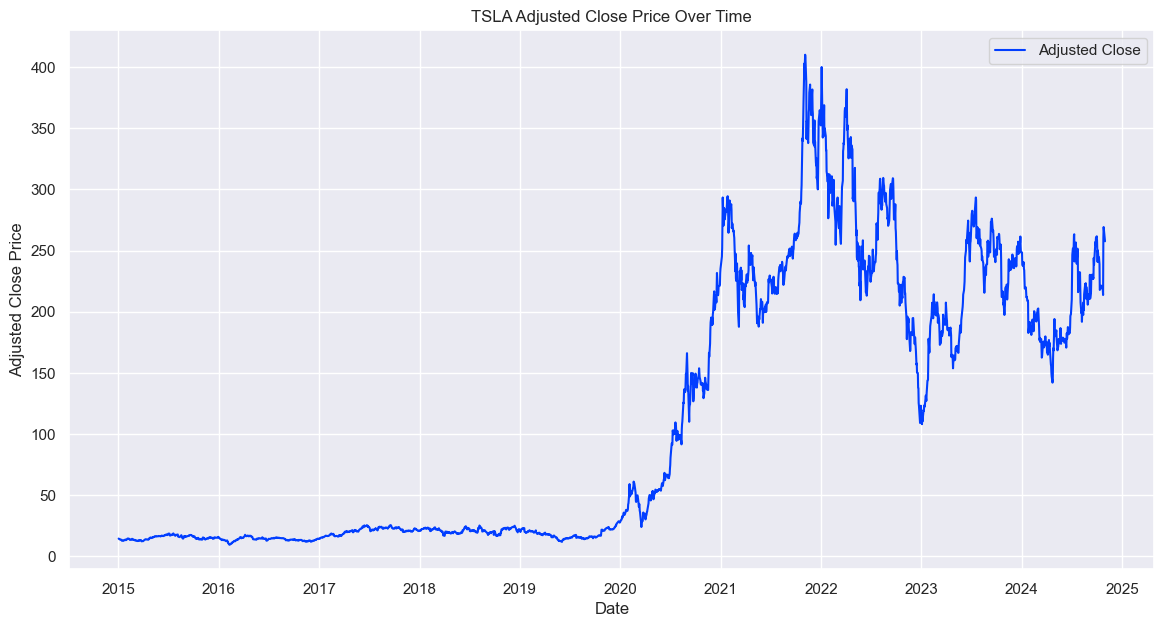

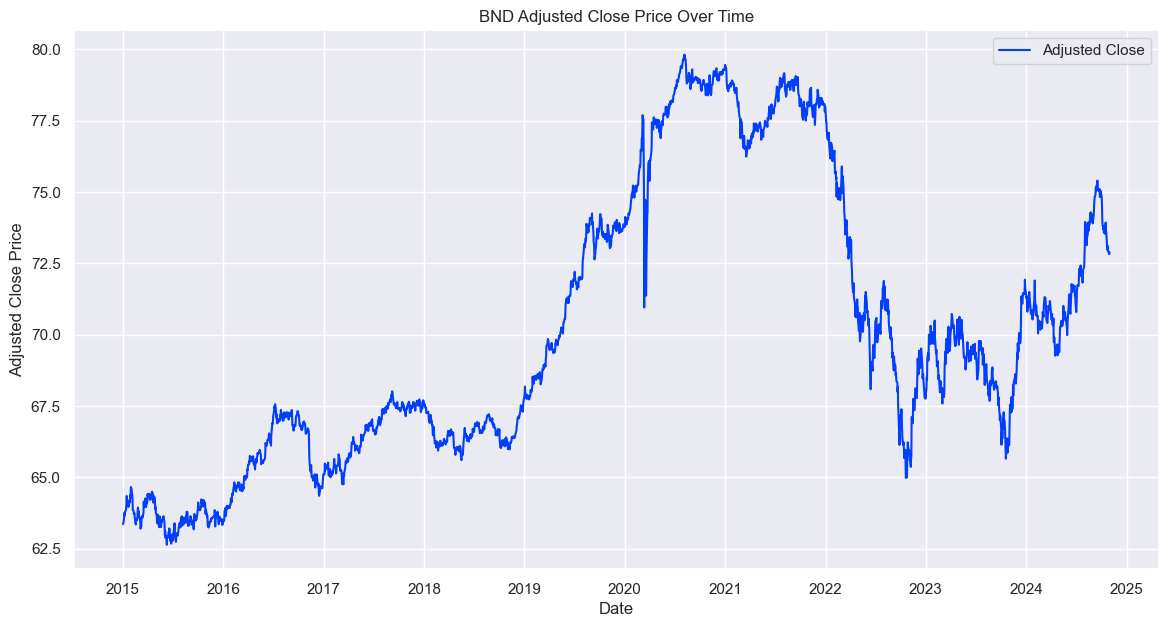

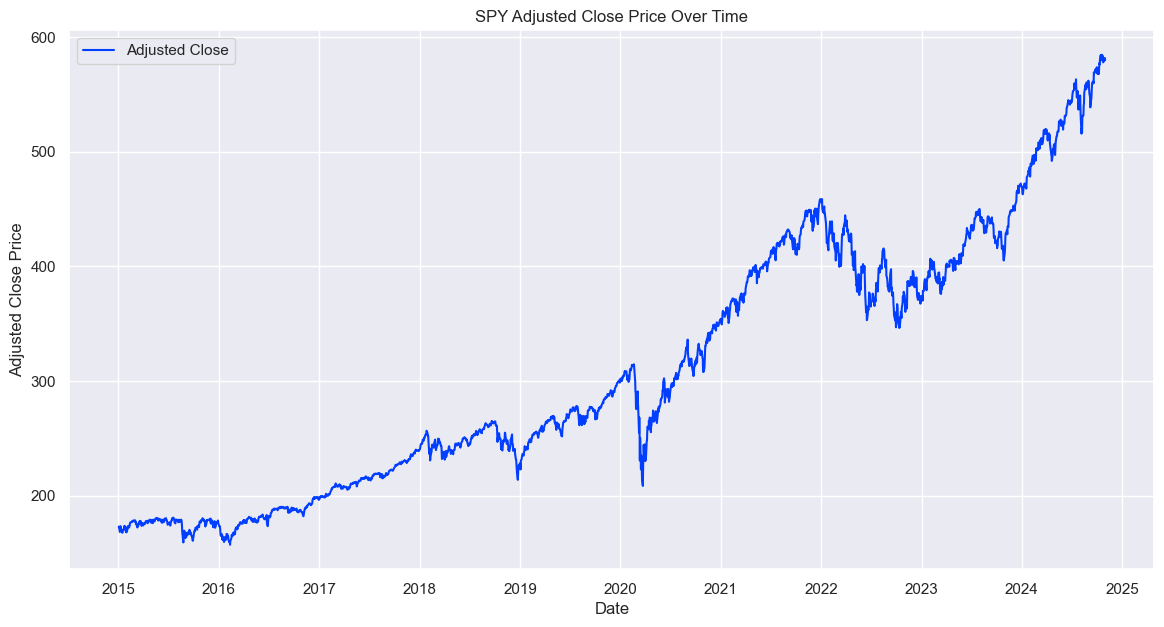

In [38]:
#Adjusted close price overtime
plot_adjusted_close(tesla_df, tesla)
plot_adjusted_close(vanguard_df, vanguard)
plot_adjusted_close(spdr_df, spdr)

### daily percentge change 

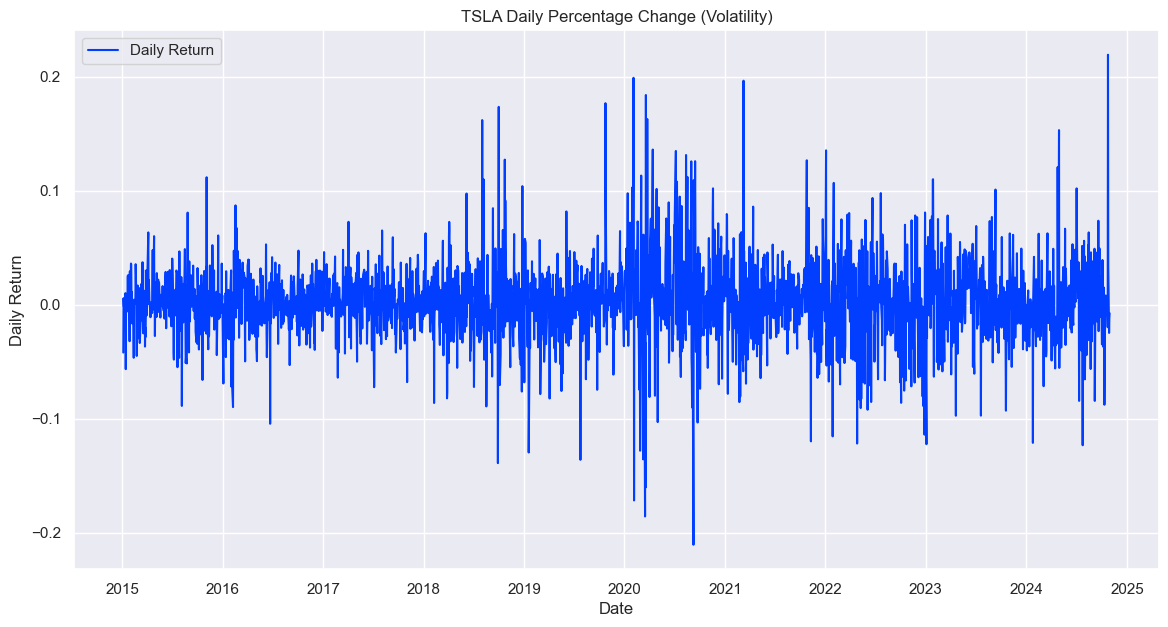

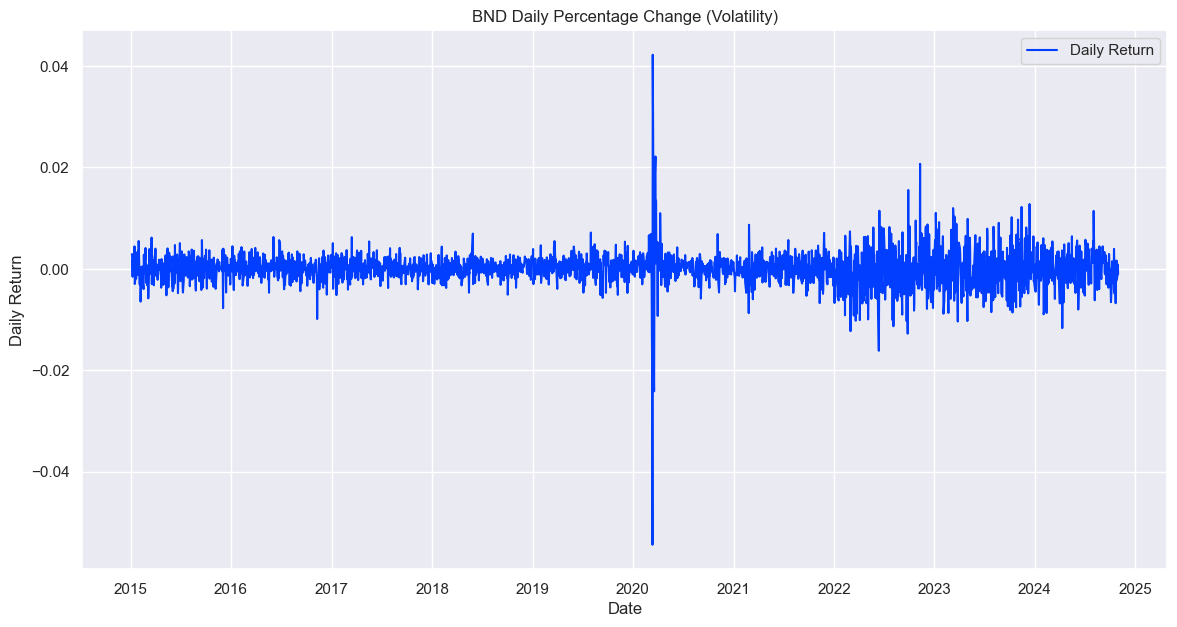

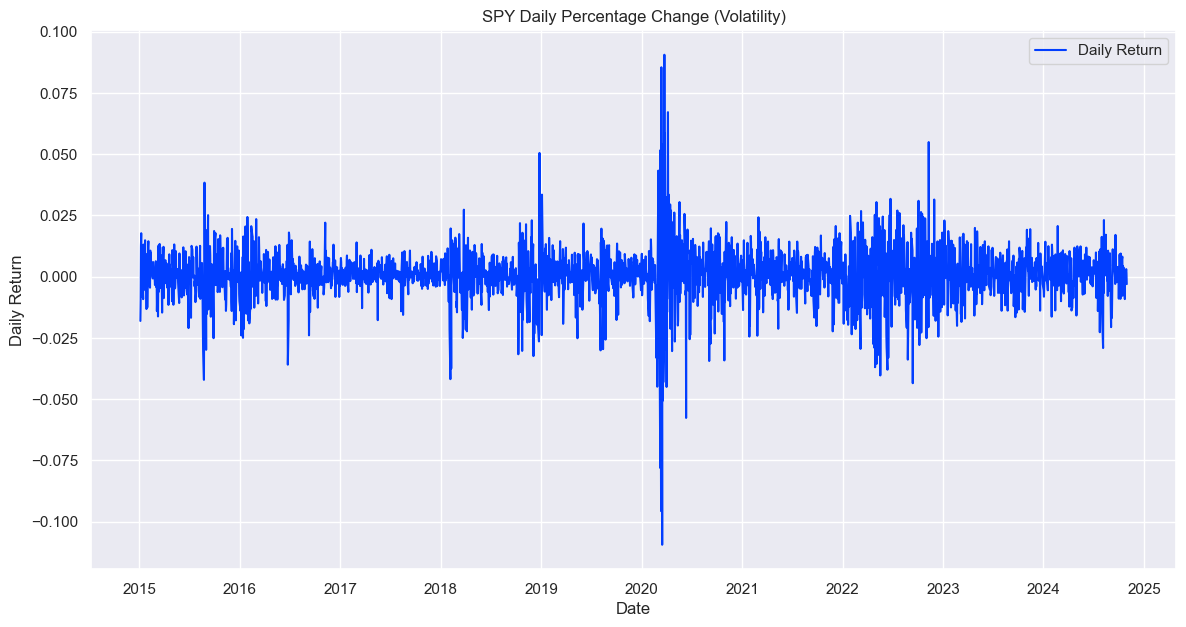

In [39]:
#daily percentge change 
plot_daily_return(tesla_df, tesla)
plot_daily_return(vanguard_df, vanguard)
plot_daily_return(spdr_df, spdr)

### Rolling mean and standard deviation

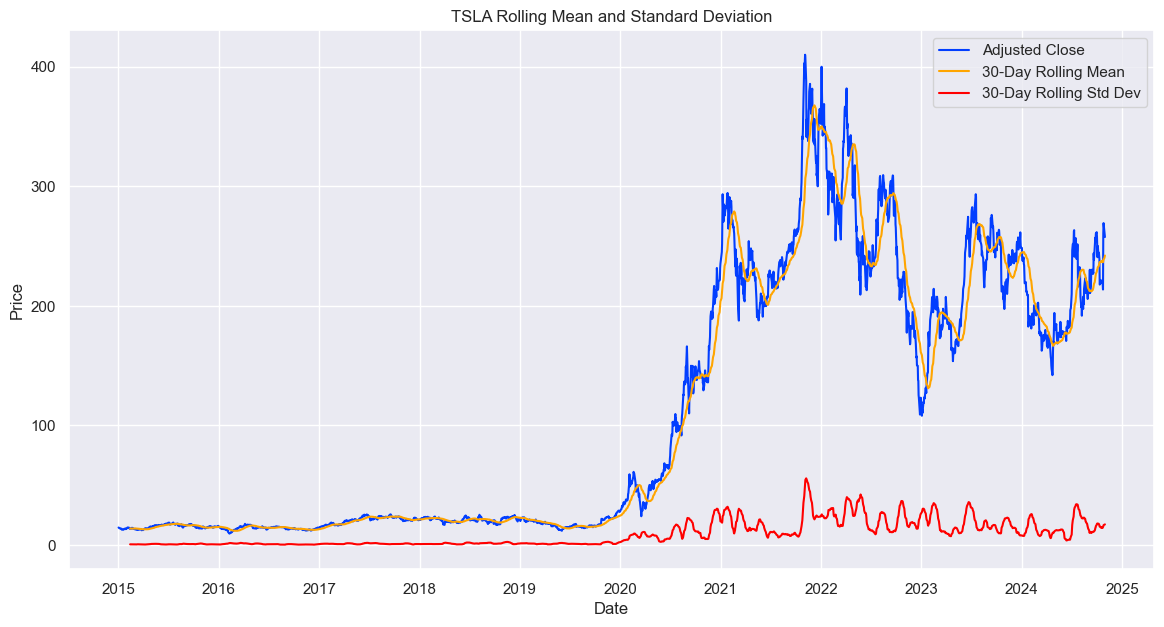

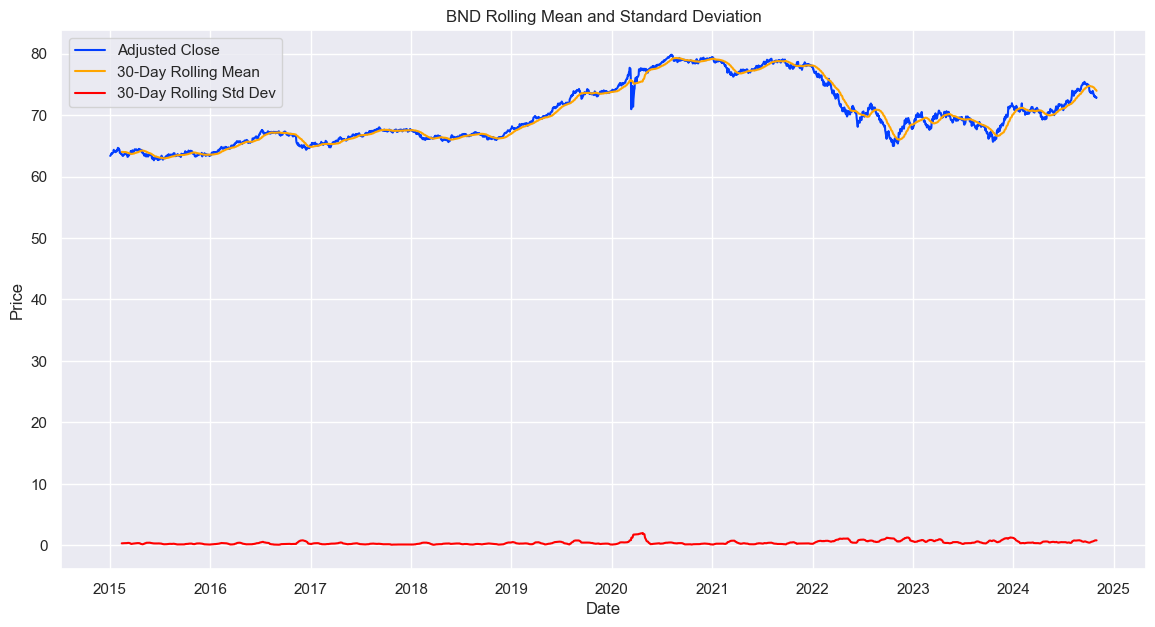

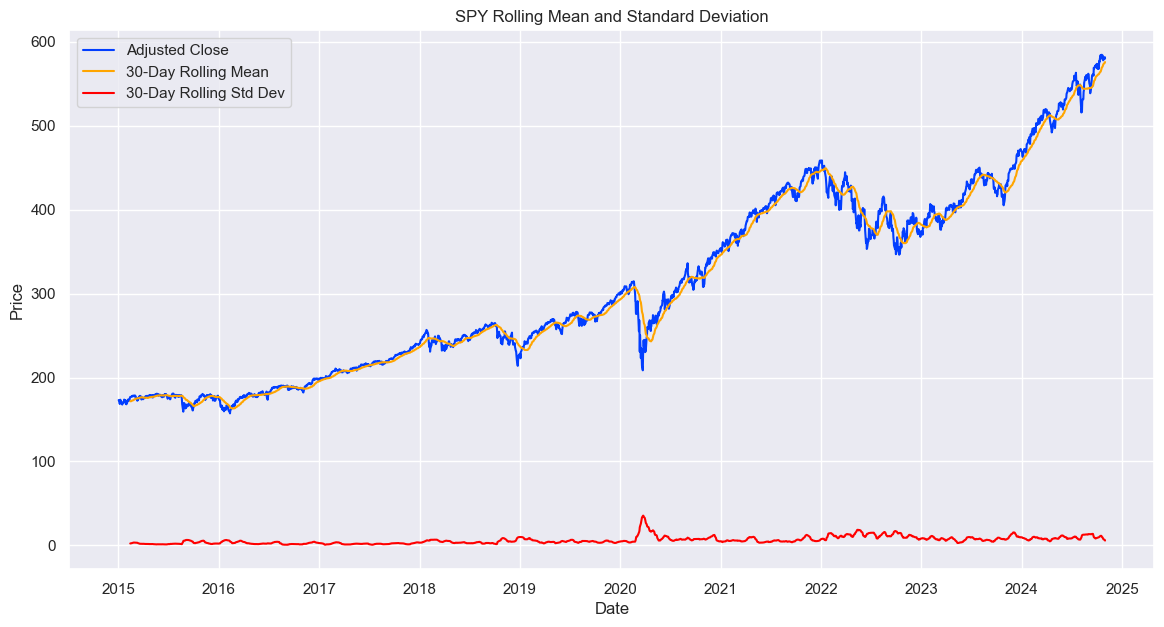

In [40]:
#30 day Rolling mean and standard deviation
plot_rolling_stats(tesla_df, tesla)
plot_rolling_stats(vanguard_df, vanguard)
plot_rolling_stats(spdr_df, spdr)

### Seasonal decomposition

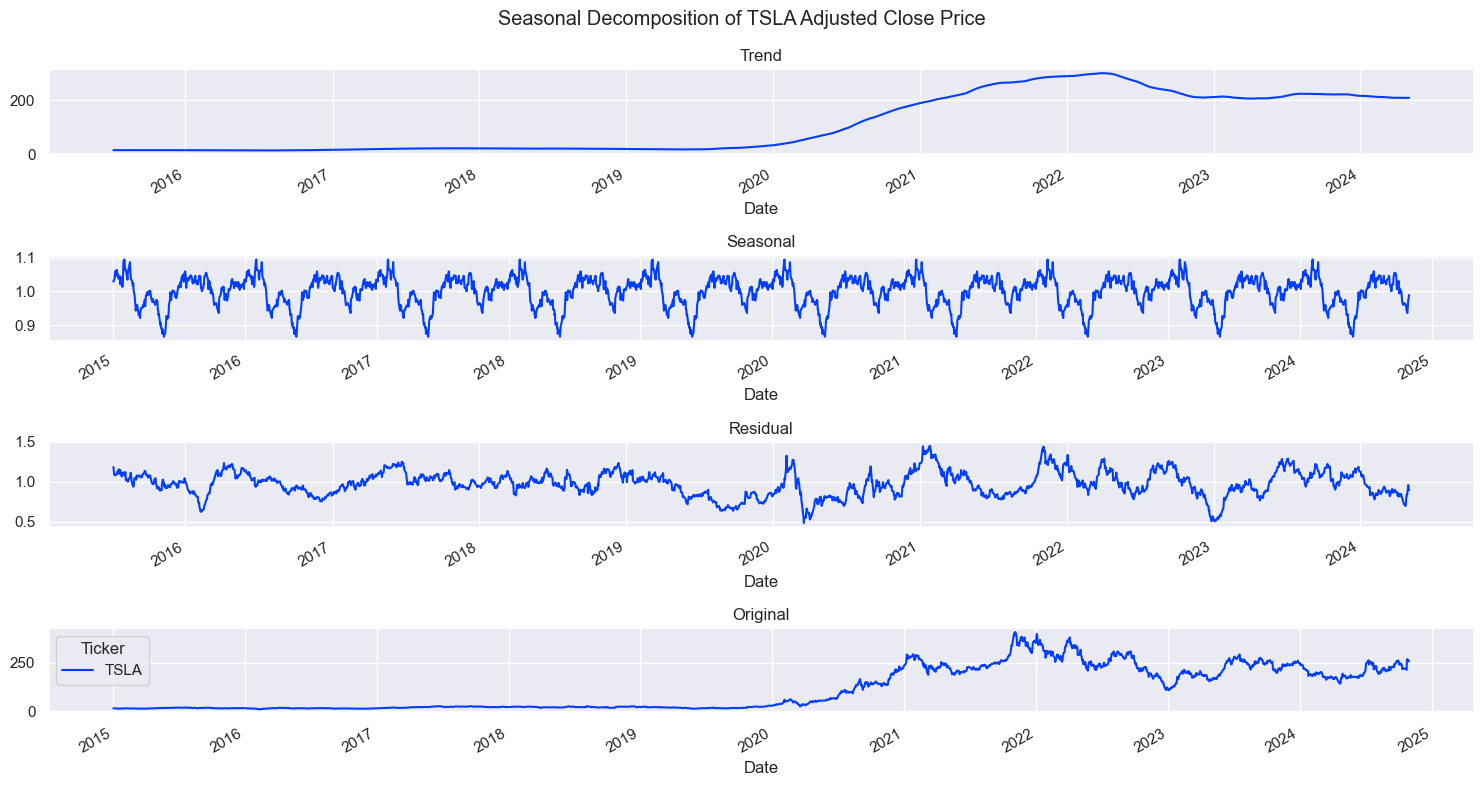

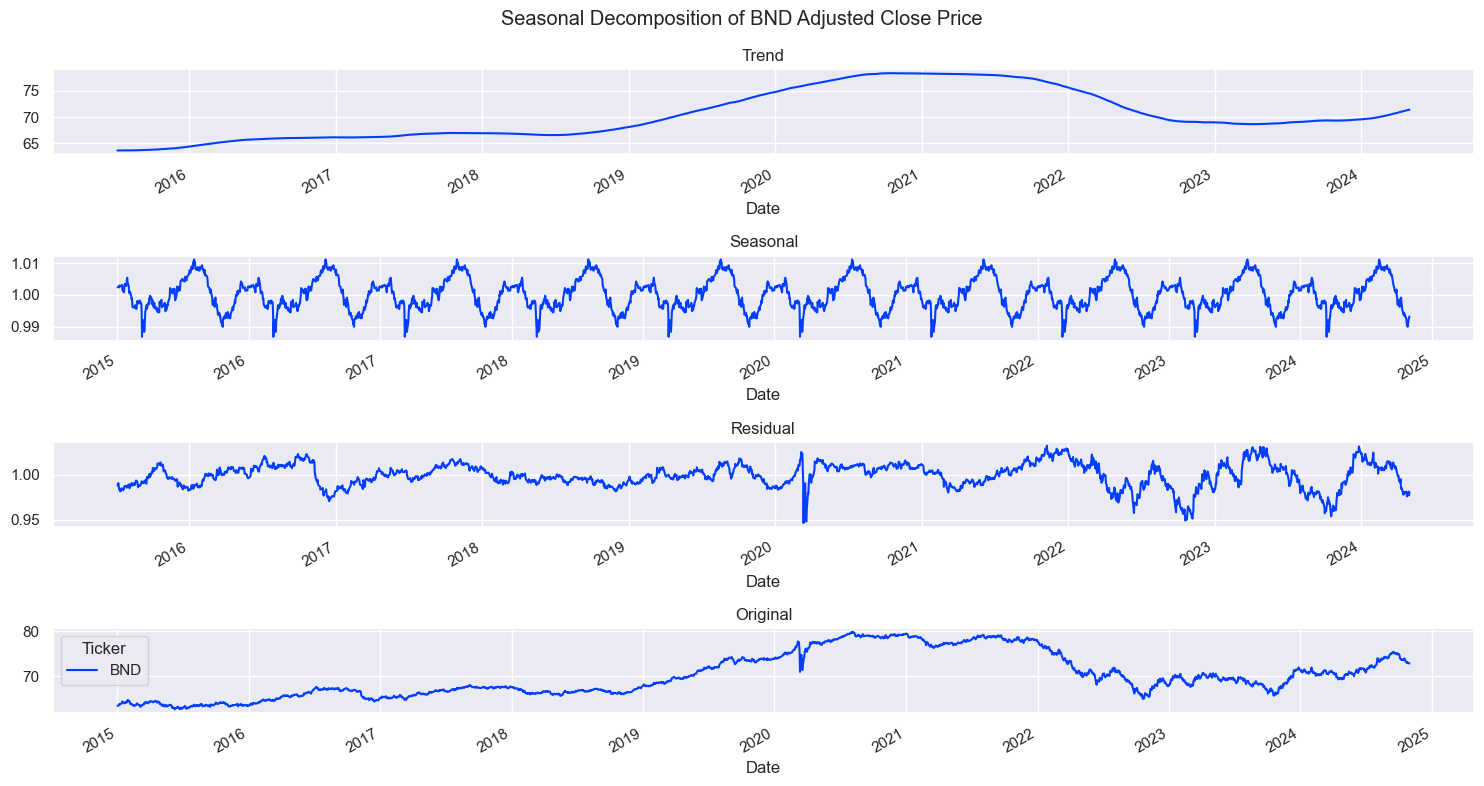

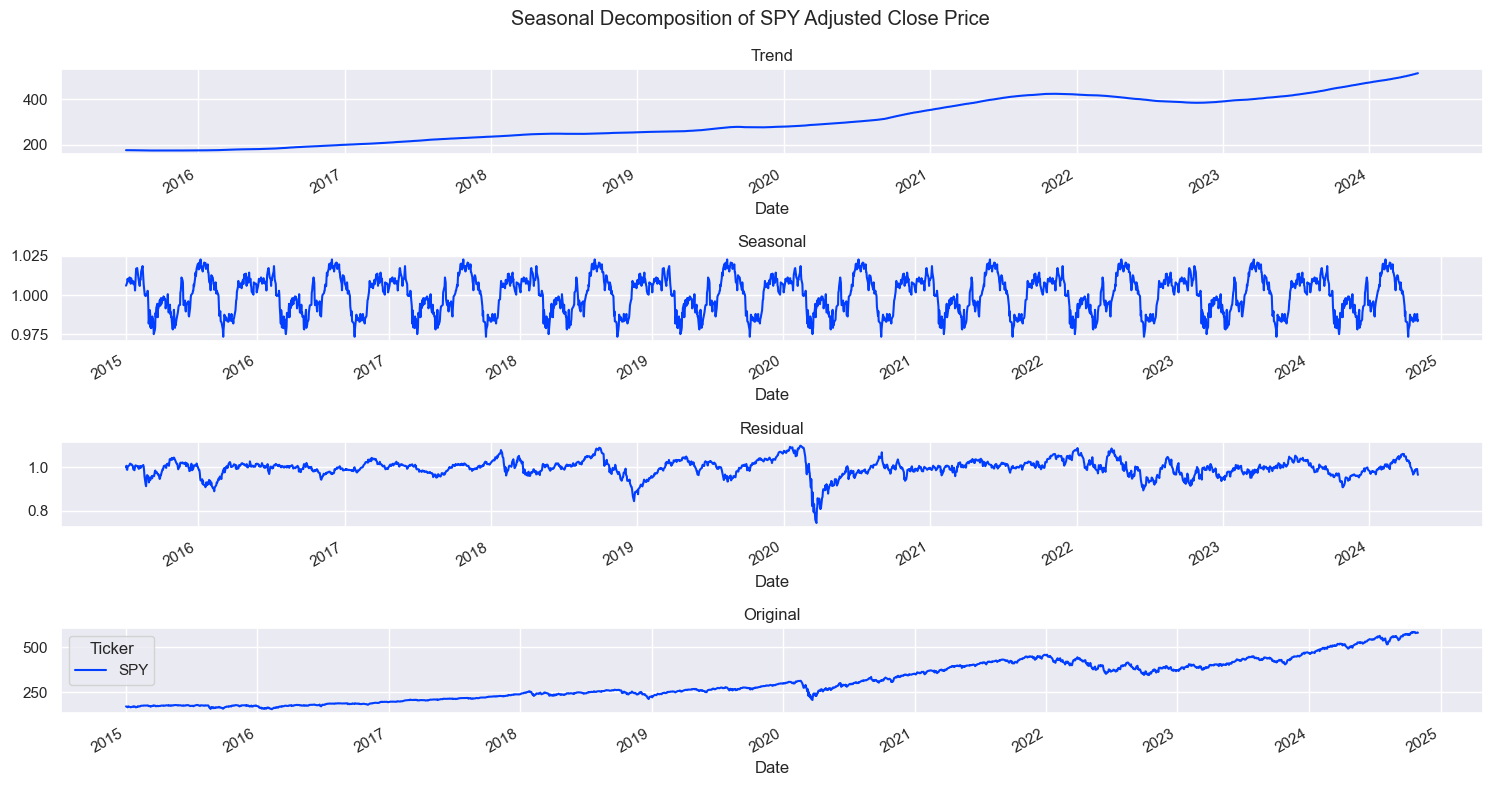

In [41]:
# Seasonal decomposition
plot_seasonal_decomposition(tesla_df, tesla)
plot_seasonal_decomposition(vanguard_df, vanguard)
plot_seasonal_decomposition(spdr_df, spdr)

### outlier detection

In [42]:
# outlier detection
detect_outliers(tesla_df, tesla)
detect_outliers(vanguard_df, vanguard)
detect_outliers(spdr_df, spdr)
    


Outliers in TSLA based on Z-Score:
 Price                                          Date Daily Return   Z-Score
Ticker                                                                    
Date                                                                      
2015-11-04 00:00:00+00:00 2015-11-04 00:00:00+00:00     0.111735  3.070649
2018-08-02 00:00:00+00:00 2018-08-02 00:00:00+00:00     0.161880  4.471264
2018-08-07 00:00:00+00:00 2018-08-07 00:00:00+00:00     0.109886  3.019009
2018-09-28 00:00:00+00:00 2018-09-28 00:00:00+00:00    -0.139015 -3.933122
2018-10-01 00:00:00+00:00 2018-10-01 00:00:00+00:00     0.173471  4.795020
2018-10-23 00:00:00+00:00 2018-10-23 00:00:00+00:00     0.127189  3.502298
2019-01-18 00:00:00+00:00 2019-01-18 00:00:00+00:00    -0.129711 -3.673244
2019-07-25 00:00:00+00:00 2019-07-25 00:00:00+00:00    -0.136137 -3.852728
2019-10-24 00:00:00+00:00 2019-10-24 00:00:00+00:00     0.176692  4.884986
2020-02-03 00:00:00+00:00 2020-02-03 00:00:00+00:00     0.19894

### Volatility metrics

In [43]:
# Volatility metrics
calculate_volatility_metrics(tesla_df, tesla)
calculate_volatility_metrics(vanguard_df, vanguard)
calculate_volatility_metrics(spdr_df, spdr)
  


Volatility Metrics for TSLA:
99% Value at Risk (VaR): -0.09037597092417465
Sharpe Ratio: 0.05024972073570675

Volatility Metrics for BND:
99% Value at Risk (VaR): -0.008750582172457189
Sharpe Ratio: 0.01814905464608497

Volatility Metrics for SPY:
99% Value at Risk (VaR): -0.032125209243292464
Sharpe Ratio: 0.04950128430338411


### auto correlation

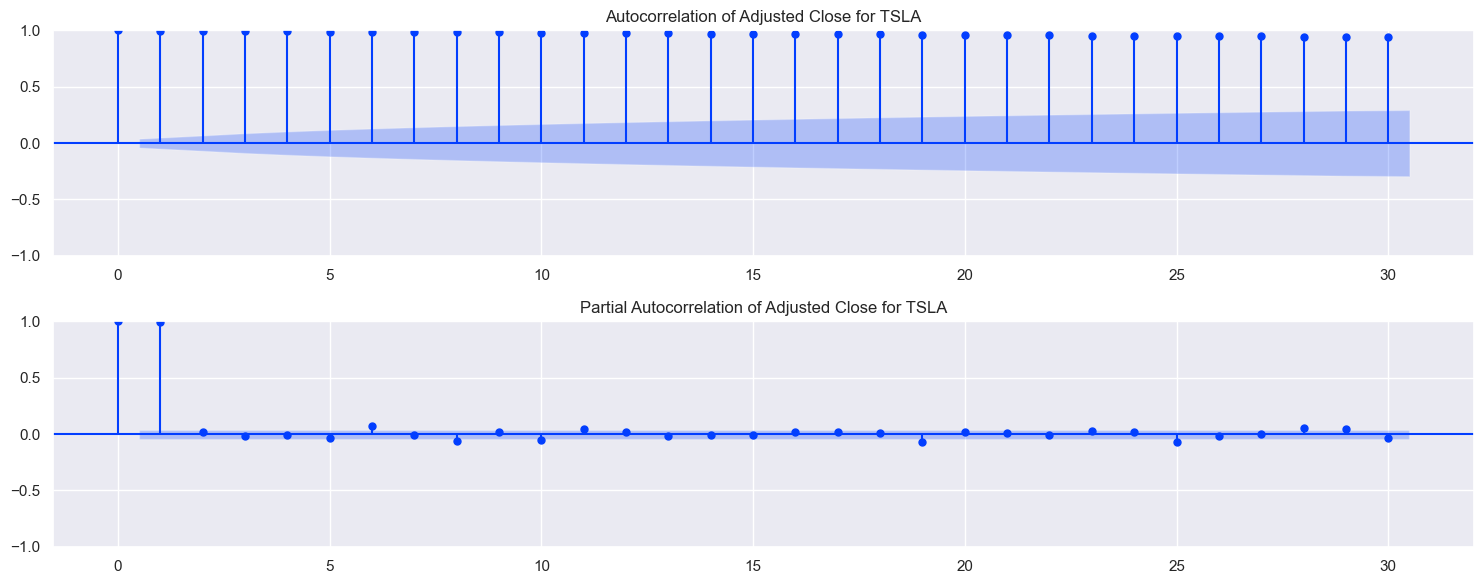

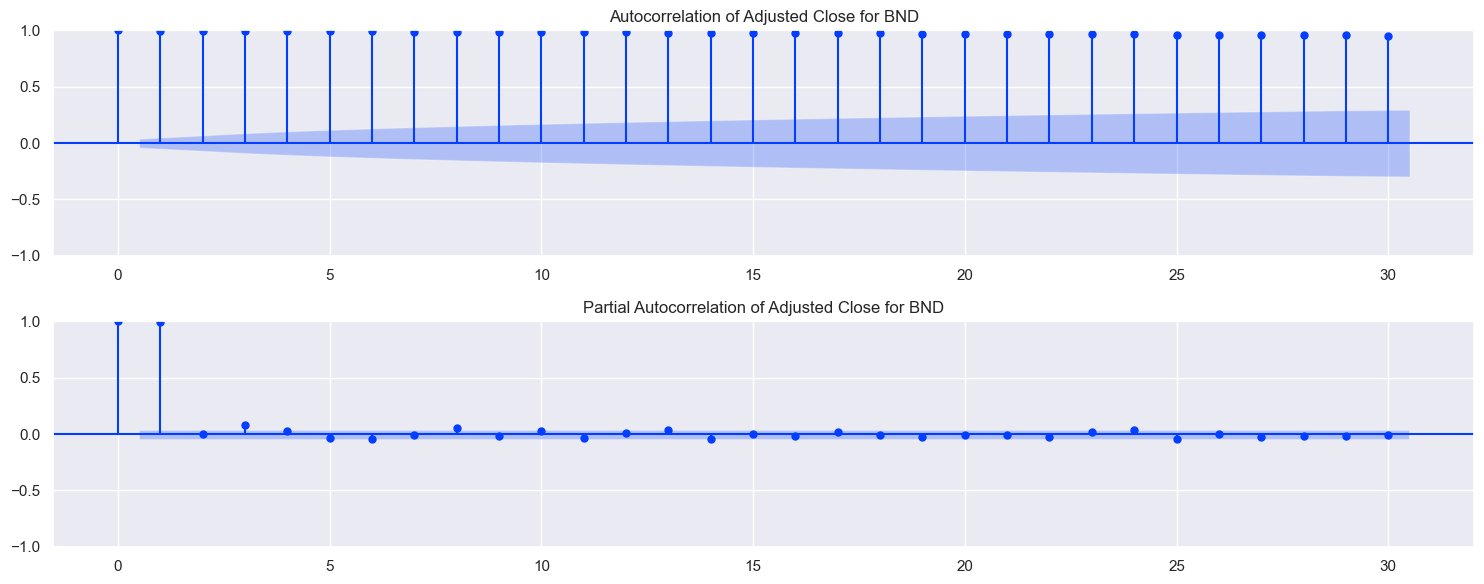

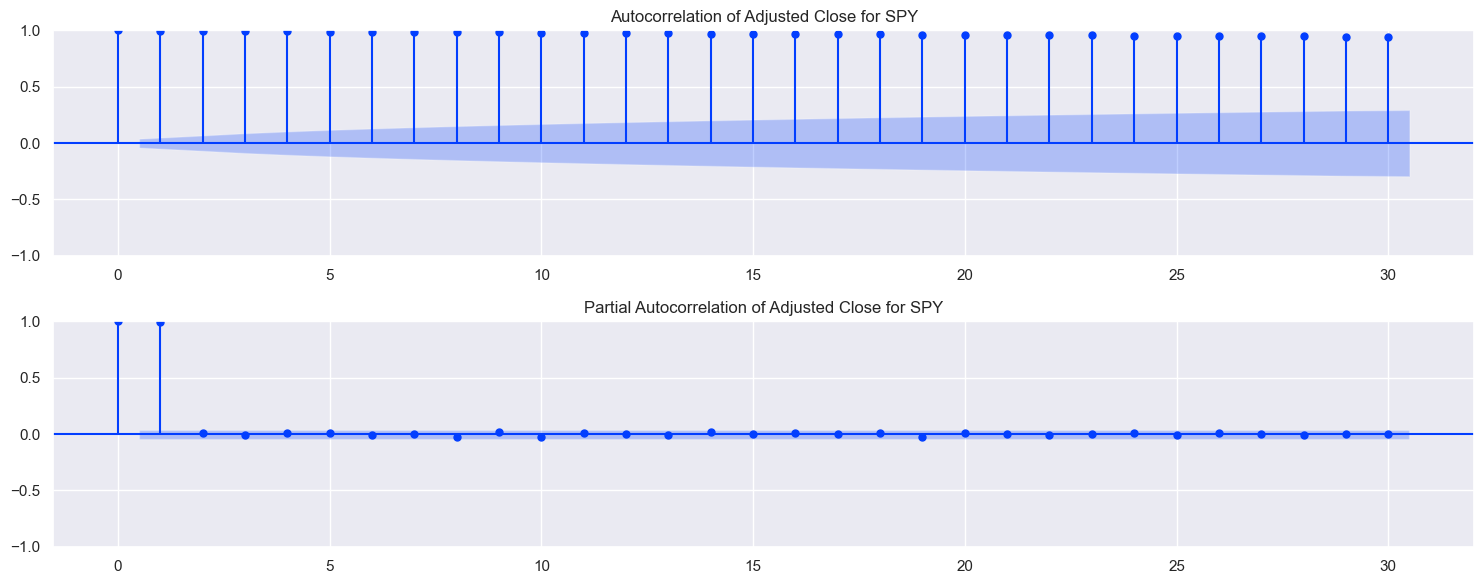

In [44]:
# auto correlation
plot_autocorrelation(tesla_df, tesla)
plot_autocorrelation(vanguard_df, vanguard)
plot_autocorrelation(spdr_df, spdr)